# Comparison of a Numpy image vs Tensor

Simulate image using Numpy and using Tensor and compare

Issues: Numpy isn't differentiable so surely won't be able to optimise?

In [1]:
import pyms
import numpy as np
import torch


from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

crystal = pyms.structure.fromfile(
    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# structure
crystal = crystal.resize([0.1, 0.76], axis=0)
from copy import deepcopy

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)


# Quick plot of crystal
# crystal.quickplot(atomscale=1e-5)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [64]:
from pyms.Probe import aberration

# Establish aberrations

df = 100.0

aberrations = []
Cs= 10.0

# Initial guesses for aberrations
A1 = 10.0
A2 = 10.0
B2 = 10.0
A3 = 10.0
S3 = 10.0
A4 = 10.0
D4 = 10.0
B4 = 10.0
C5 = 10.0
A5 = 10.0
S5 = 10.0
R5 = 10.0

# Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
# n and m are constants (shouldn't be differentiable), amplitude and angle should be

aberrations.append(aberration("C10", "C1", "Defocus          ", df, 0.0, 1, 0.0))
aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", A1, 0.0, 1, 0.0))
aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", A2, 0.0, 2, 3.0))
aberrations.append(aberration("C21", "B2", "Axial coma       ", B2, 0.0, 2, 1.0))
aberrations.append(aberration("C30", "C3", "3rd order spher. ", Cs, 0.0, 3, 0.0))
aberrations.append(aberration("C34", "A3", "4-Fold astig.    ", A3, 0.0, 3, 4.0))
aberrations.append(aberration("C32", "S3", "Axial star aber. ", S3, 0.0, 3, 2.0))
aberrations.append(aberration("C45", "A4", "5-Fold astig.    ", A4, 0.0, 4, 5.0))
aberrations.append(aberration("C43", "D4", "3-Lobe aberr.    ", D4, 0.0, 4, 3.0))
aberrations.append(aberration("C41", "B4", "4th order coma   ", B4, 0.0, 4, 1.0))
aberrations.append(aberration("C50", "C5", "5th order spher. ", C5, 0.0, 5, 0.0))
aberrations.append(aberration("C56", "A5", "6-Fold astig.    ", A5, 0.0, 5, 6.0))
aberrations.append(aberration("C52", "S5", "5th order star   ", S5, 0.0, 5, 2.0))
aberrations.append(aberration("C54", "R5", "5th order rosette", R5, 0.0, 5, 4.0))


#defocus = torch.tensor([df], requires_grad = True)
defocus = aberrations[0].amplitude


In [60]:
output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    aberrations=aberrations,
    df= aberrations[0].amplitude,
    tiling=tiling,
    nfph=1,
    showProgress='notebook', 
    apply_ctf = False,
)

import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(output)

print(output.size())

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([683, 683])


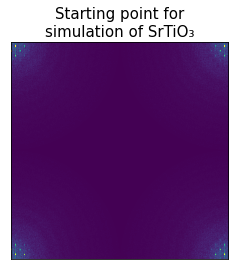

In [80]:
plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)

In [16]:
path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'

ref_data = np.load(path)
ref_data = torch.tensor(ref_data).to('cpu') # change cuda to cpu

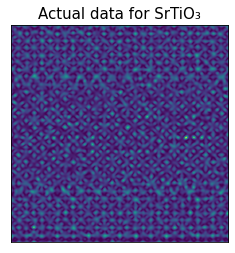

In [84]:
plt.imshow(torch.abs(ref_data).numpy()) # removed .cpu and .detach and vmax=10 (vmax was the thing causing issues)

Okay so it's this part that I obviously can't differentiate?

In [ ]:
# Go back to source code

# After output its this

import matplotlib.pyplot as plt
%matplotlib inline
ny,nx = output.shape[-2:]
# Plot images
fig, ax = plt.subplots(figsize=(16,16))
ax.set_xticks(np.arange(nx/2,(len(thicknesses)+0.5)*nx,nx))
ax.set_xticklabels(thicknesses)
ax.set_xlabel('Thickness ($\AA$)')
ax.set_yticks(np.arange(ny/2,(len(df)+0.5)*ny,ny))
ax.set_yticklabels(df)
ax.set_ylabel('Defocus ($\AA$)')

# Stack defocii (first dimension of output) and thicknesses (second dimension of output)
# to make a thickness defocus series
ax.imshow(np.hstack(np.hstack(output)))


In [65]:
bw_limit_size = size_of_bandwidth_limited_array(gridshape)
rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

curves = []

# Generic form allows more flexibility if we decided to not include some aberrations in the future.
for i in range(0, len(aberrations)):
    params.append(aberrations[i].amplitude)
    curves.append([]) # create a curve for each differentiable quantity

optimizer = torch.optim.Adam(params, lr = 1e-1)
criterion = torch.nn.MSELoss()
n_iters = 2000

loss_curve = []
#defocii_curve = []
#A1_curve = []
#A2_curve = []
#B2_curve = []
#Cs_curve = []
#A3_curve = []
#S3_curve = []
#A4_curve = []
#D4_curve = []
#B4_curve = []
#C5_curve = []
#A5_curve = []
#S5_curve = []
#R5_curve = []


for iter in range(n_iters):
    ctf = (
            torch.stack(
                [
                    make_contrast_transfer_function(
                        bw_limit_size, rsize, eV, app, df=defocus, aberrations=aberrations
                    )
                ]
            )
        .type(torch.complex128)
        .to('cpu') # changed cuda to cpu
    )

    sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))
    
    optimizer.zero_grad()
    
    loss = criterion(sim_image, ref_data)*1000000000

    loss.backward()

    optimizer.step()

    loss_curve.append(loss.item())
    
    # This should be made more generic
    
    for i in range(0,len(curves)):
        curves[i].append(aberrations[i].amplitude.item())

    #defocii_curve.append(defocus.item())
    #A1_curve.append(aberrations[1].amplitude.item())
    #A2_curve.append(aberrations[2].amplitude.item())
    #B2_curve.append(aberrations[3].amplitude.item())
    #Cs_curve.append(aberrations[4].amplitude.item())
    #A3_curve.append(aberrations[5].amplitude.item())
    #S3_curve.append(aberrations[6].amplitude.item())
    #A4_curve.append(aberrations[7].amplitude.item())
    #D4_curve.append(aberrations[8].amplitude.item())
    #B4_curve.append(aberrations[9].amplitude.item())
    #C5_curve.append(aberrations[10].amplitude.item())
    #A5_curve.append(aberrations[11].amplitude.item())
    #S5_curve.append(aberrations[12].amplitude.item())
    #R5_curve.append(aberrations[13].amplitude.item())
    

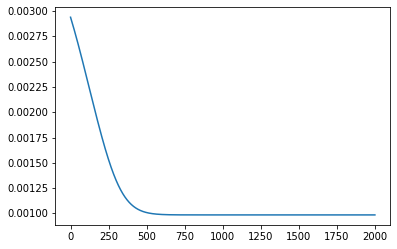

In [66]:
plt.plot(loss_curve)

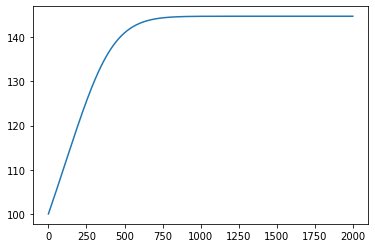

In [67]:
# This is how the defocus value changes
plt.plot(curves[0])

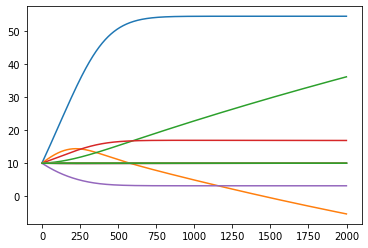

In [68]:
# This is how the aberrations values change

for i in range(1, len(curves)):
    plt.plot(curves[i])

Interesting how poorly the optimisation is performing

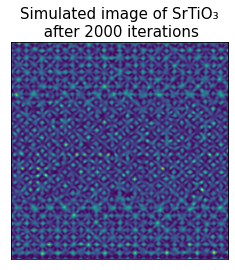

In [79]:
plt.imshow(sim_image[0].detach().cpu().numpy())

plt.title(u'Simulated image of SrTiO\u2083\n after 2000 iterations NUMPY', fontsize=15)
plt.xticks([])
plt.yticks([])

filepath = "/home/hremadmin/Documents/Project/ML_files/X.jpg"
plt.savefig(filepath, dpi=500)

In [70]:
import os
os.getcwd()

'/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos'

Ignore below

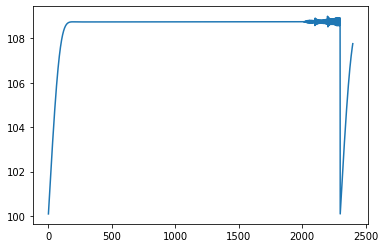

In [52]:
plt.plot(defocii_curve)

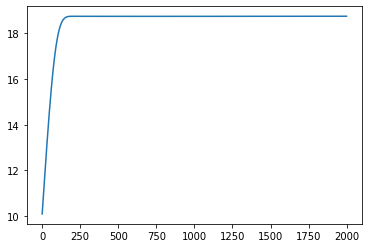

In [21]:
plt.plot(A1_curve)

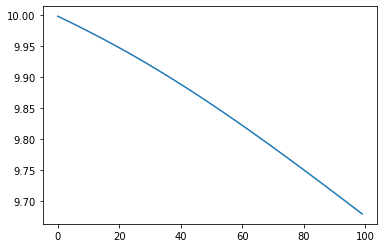

In [58]:
plt.plot(curves[5])

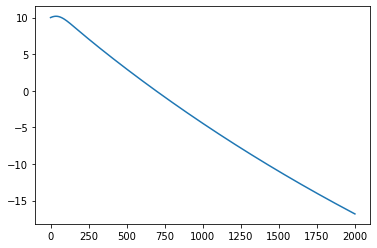

In [22]:
plt.plot(A2_curve)

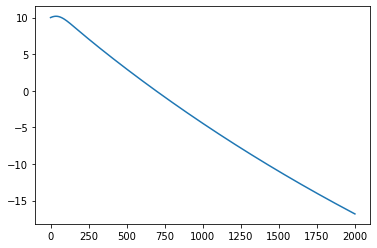

In [23]:
plt.plot(A2_curve)

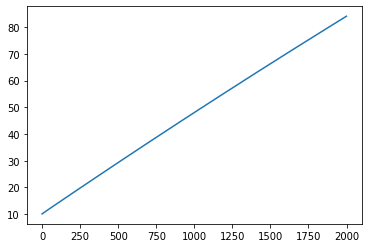

In [24]:
plt.plot(B2_curve)

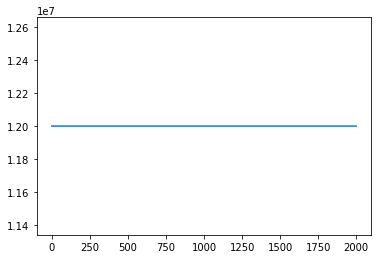

In [25]:
plt.plot(Cs_curve)

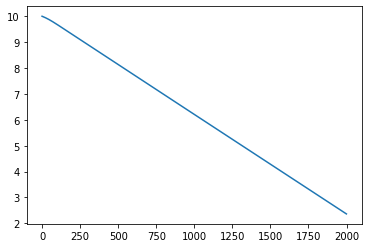

In [26]:
plt.plot(A3_curve)

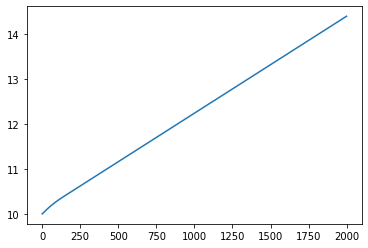

In [27]:
plt.plot(S3_curve)

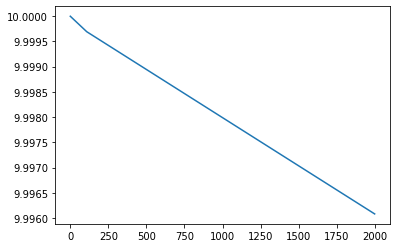

In [28]:
plt.plot(A4_curve)

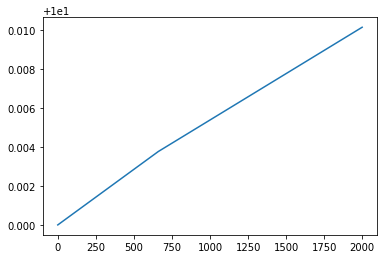

In [29]:
plt.plot(B4_curve)

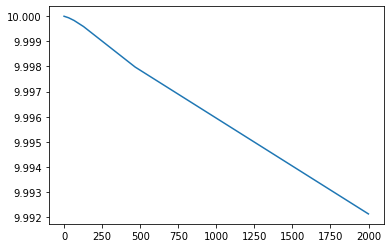

In [30]:
plt.plot(D4_curve)

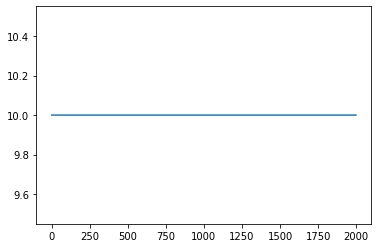

In [31]:
plt.plot(C5_curve)

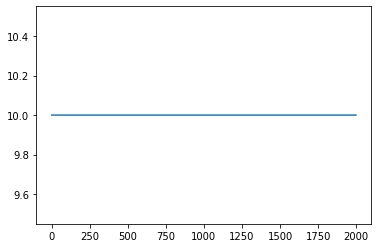

In [32]:
plt.plot(A5_curve)

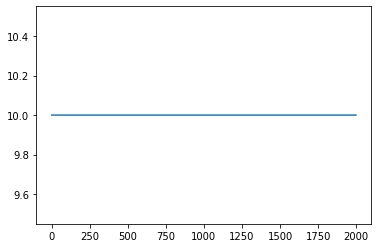

In [33]:
plt.plot(R5_curve)

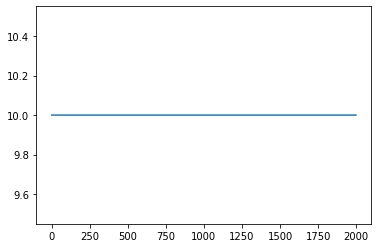

In [34]:
plt.plot(S5_curve)